In [38]:
import tifffile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm

In [39]:
# build the colormap with iterative tab10
tab20 = cm.get_cmap('tab20', 10)
for i in range(10):
    tab20.colors = np.concatenate([tab20.colors,tab20.colors],axis=0)    
tab20.colors = np.concatenate([np.zeros([1,4]),tab20.colors],axis=0)

newmap = cm.get_cmap('tab20', 4000+1)
newmap.colors = tab20.colors[0:4000+1,:]
newmap.colors[0,:]  = np.zeros([1,4])
newmap.colors[0,3] = 1

In [41]:
GT_folder = 'D:/Ding/UChicago/cellsegmentation/data/tissuenet_v1.1/tiff/C1_selected_GT'
pred_folder = 'D:/Ding/UChicago/cellsegmentation/data/tissuenet_v1.1/tiff/C0_selected_seg_stardist'
output_folder = 'D:/Ding/UChicago/cellsegmentation/data/tissuenet_v1.1/tiff/C0_selected_seg_stardist_iou'
if not os.path.isdir(output_folder):   os.makedirs(output_folder)

current_accum = []
all_iou_table = pd.DataFrame(columns={'filename','method','seg_label','GT_lable','iou'})

method_name = 'stardist'
ch_name = 'nuclei'

filenames = [x for x in os.listdir(GT_folder) if os.path.isfile(os.path.join(GT_folder, x)) and ('.tif' in x)]
    
for filenameID in range(0,min(len(filenames),10)):

    filename = filenames[filenameID]
    iou_table = pd.DataFrame(columns={'filename','method','seg_label','GT_lable','iou'})

    GT_labels = tifffile.imread(os.path.join(GT_folder, filename))
    new_filename =  filename.replace("seg_C1", "img_C0")
    pred_labels = tifffile.imread(os.path.join(pred_folder, 'label_'+new_filename[:-1]+'.tif'))
                             
    pred_labels = (pred_labels+2)*(pred_labels>0)
    GT_labels = (GT_labels+2)*(GT_labels>0)

    gt_label_list = np.unique(GT_labels)   
    pred_label_list = np.unique(pred_labels)
    
   
    for label_i in pred_label_list:
        if(label_i==0 or label_i >100000000000):
            continue

        pred_mask = pred_labels == label_i

        map_list = GT_labels[pred_mask>0]
        map_list = map_list[map_list>0]

        if(map_list.shape[0]==0):
            current_accum.append(0)
            current_jacc = 0
            current_accum.append(current_jacc)
            s = pd.Series([filenames, method_name, ch_name, label_i, 0,current_jacc], index=['filename','method','channel','seg_label','GT_lable','iou'])
            iou_table = iou_table.append(s,ignore_index=True)
            continue

        values, counts = np.unique(map_list, return_counts=True)

        ind = np.argmax(counts)
        gt_label = values[ind]     

        true_mask = GT_labels == gt_label

        union = pred_mask.astype(int) + 2 * true_mask.astype(int)

        [ind_x, ind_y] = np.where(union>0)

        min_x = max(min(ind_x)-2,0)
        max_x = min(max(ind_x)+2,pred_mask.shape[0])
        min_y = max(min(ind_y)-2,0)
        max_y = min(max(ind_y)+2,pred_mask.shape[1])
        

        current_jacc = (np.sum(np.logical_and(true_mask[min_x:max_x, min_y:max_y], pred_mask[min_x:max_x, min_y:max_y])) /
            np.sum(np.logical_or(true_mask[min_x:max_x, min_y:max_y], pred_mask[min_x:max_x, min_y:max_y])))


        current_accum.append(current_jacc)

        if(filenameID>100000):

            cropX, cropY = np.meshgrid(np.arange(0,pred_mask[min_x:max_x, min_y:max_y].shape[1]), np.arange(0,pred_mask[min_x:max_x, min_y:max_y].shape[0]))
            

            fig, ax = plt.subplots(2,3, figsize=(12,6), dpi=256, facecolor='w', edgecolor='k')
            ax[0,0].imshow(pred_mask[min_x:max_x, min_y:max_y].astype(int)*1, cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
            ax[0,0].axis('off')
            ax[0,0].title.set_text('seg_label='+"%d" % label_i)

            ax[0,1].imshow(true_mask[min_x:max_x, min_y:max_y].astype(int)*2, cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
            ax[0,1].axis('off')
            ax[0,1].title.set_text('GT_label='+"%d" % gt_label)
            
            ax[0,2].imshow( pred_mask[min_x:max_x, min_y:max_y].astype(int)*1 + 2 * true_mask[min_x:max_x, min_y:max_y].astype(int), cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
            ax[0,2].axis('off')
            # ax[0,2].contour(cropX, cropY, pred_mask[min_x:max_x, min_y:max_y].astype(int)* true_mask[min_x:max_x, min_y:max_y].astype(int),1,colors=('yellow'),linewidths=0.5)
            ax[0,2].title.set_text('iou='+"%.2f" % current_jacc)


            X, Y = np.meshgrid(np.arange(0,pred_labels.shape[1]), np.arange(0,pred_labels.shape[0]))
            
            ax[1,0].imshow(pred_labels, cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
            ax[1,0].axis('off')
            ax[1,0].plot( [min_y,max_y,max_y,min_y,min_y],[min_x,min_x,max_x,max_x,min_x])
            ax[1,0].contour(X, Y, pred_mask,1,colors=('yellow'),linewidths=0.7)
                        
            
            ax[1,1].imshow(GT_labels, cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
            ax[1,1].axis('off')
            ax[1,1].contour(X, Y, true_mask,1,colors=('yellow'),linewidths=0.7)
            ax[1,1].plot( [min_y,max_y,max_y,min_y,min_y],[min_x,min_x,max_x,max_x,min_x])
            ax[1,2].axis('off')
            fig.savefig(os.path.join(output_folder,filename+'_'+method_name+'_'+ch_name+'_seg'+str(label_i) + '_GT'+str(gt_label)+'.png'))

            plt.close(fig)      

        s = pd.Series([filename, method_name, ch_name, label_i, gt_label,current_jacc], index=['filenames','method','channel','seg_label','GT_lable','iou'])
            
        iou_table = iou_table.append(s,ignore_index=True)

    iou_table.to_csv(os.path.join(output_folder,filename+'_'+method_name+'_'+ch_name+'_iou.csv'))
    # all_iou_table = all_iou_table.append(iou_table,axis=0)
    
# all_iou_table.to_csv(os.path.join(output_folder,'all_'+method_name+'_'+ch_name+'_iou.csv'))
   

Text(0, 45, 'Precision=0.86')

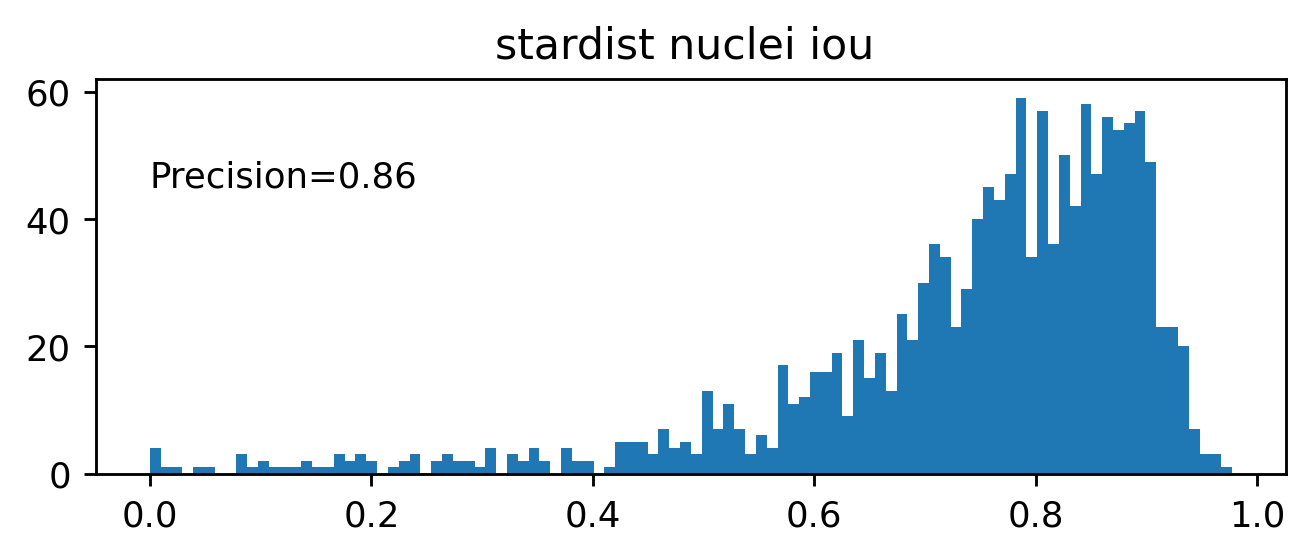

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(6,2), dpi=256, facecolor='w', edgecolor='k')
plt.hist(current_accum,100)
plt.title(method_name+' '+ch_name+' iou ')
res = np.array(current_accum)
plt.text(0,45,'Precision='+ "%.2f" % (res[res>0.6].shape[0]/res.shape[0]))

In [ ]:


non_nan = [x for x in current_accum if x == x]


Text(0.5, 1.0, 'stardist nuclei iou ')

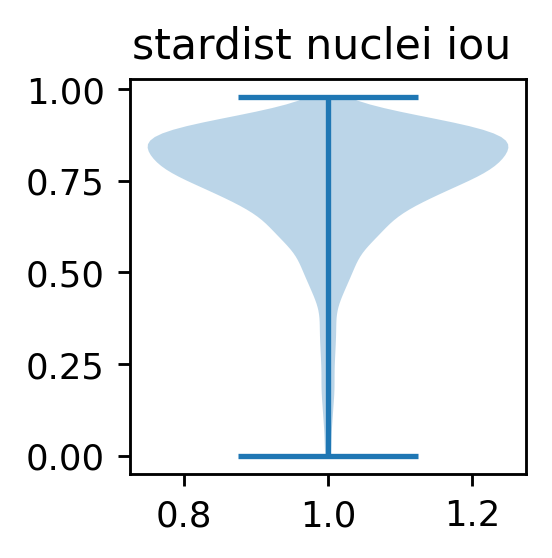

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi=256, facecolor='w', edgecolor='k')
plt.violinplot(non_nan)
plt.title(method_name+' '+ch_name+' iou ')

Text(0.5, 1.0, 'stardist nuclei iou ')

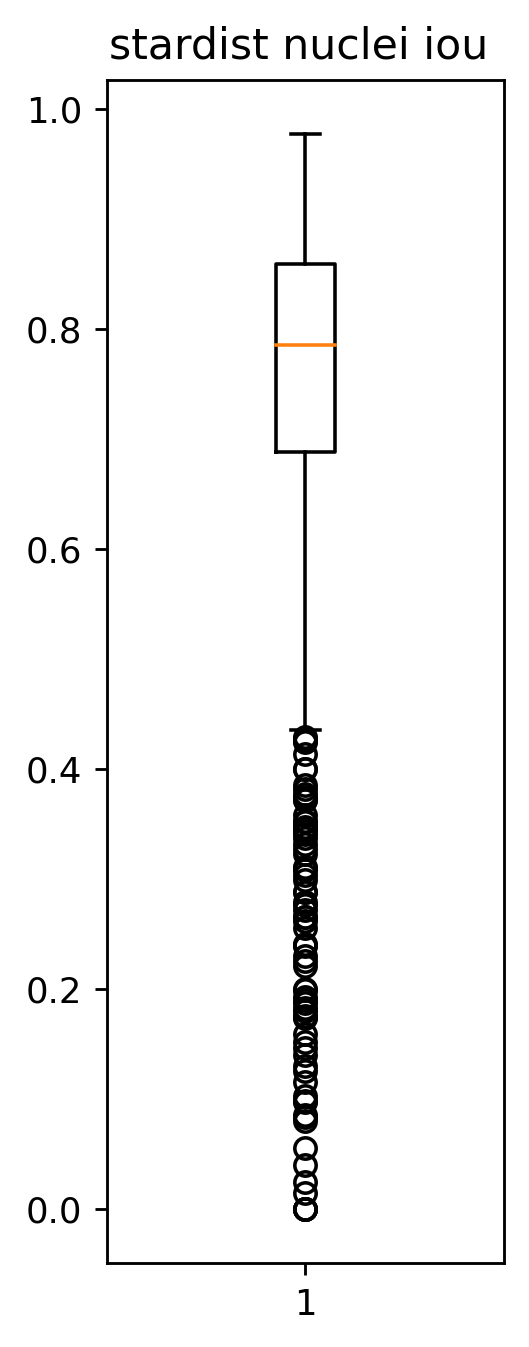

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(2,6), dpi=256, facecolor='w', edgecolor='k')
plt.boxplot(current_accum)
plt.title(method_name+' '+ch_name+' iou ')